In [220]:
from scipy.stats import beta, rv_continuous
import plotly.express as px
import numpy as np
import polars as pl
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, accuracy_score, f1_score
from typing import Callable

import dataclasses

def beta_from_params(EV: float, conf: float) -> rv_continuous:
    conf = 2**conf
    a = np.sqrt(EV*conf/(1-EV))
    b = conf/a
    return beta(a, b)

@dataclasses.dataclass
class ModelConfig:
    pos_pred_EV: list[float]
    pos_pred_confidence: list[float]
    neg_pred_EV: list[float]
    neg_pred_confidence: list[float]

    def __post_init__(self):
        for n in ["pos_pred_EV", "pos_pred_confidence", "neg_pred_EV", "neg_pred_confidence"]:
            val = getattr(self, n)
            if type(val) is not list:
                raise TypeError(f"{n} must be a list. Found {type(val)}")
            if len(val) != self.n_subgroups:
                raise ValueError(
                    f"All distribution parameters must have the same number of subgroups ({self.n_subgroups}). "
                    f"{n} has {len(val)}."
                )
            for v in val:
                if n.endswith("_EV") and (v <= 0 or v >= 1):
                    raise ValueError(f"{n} must be a list of floats v such that 0 < v < 1. Found {v}")
    
    @property
    def n_subgroups(self) -> int:
        return len(self.pos_pred_EV)

    @property
    def pos_rvs(self):
        return [beta_from_params(ev, conf) for ev, conf in zip(self.pos_pred_EV, self.pos_pred_confidence)]
    @property
    def neg_rvs(self):
        return [beta_from_params(ev, conf) for ev, conf in zip(self.neg_pred_EV, self.neg_pred_confidence)]

    def viz(self, N_plot_samples: int = 100):
        plot_data = {"subgroup": [], "X": [], "Y": [], "prob_type": []}
        for subgroup in range(self.n_subgroups):
            pos_rv = self.pos_rvs[subgroup]
            neg_rv = self.neg_rvs[subgroup]

            X = np.arange(0., 1., 1/N_plot_samples)
            pos_pdf = pos_rv.pdf(X)
            neg_pdf = neg_rv.pdf(X)
            likelihood_of_pos = pos_pdf / (pos_pdf + neg_pdf)

            for x, p, n, L in zip(X, pos_pdf, neg_pdf, likelihood_of_pos):
                plot_data["subgroup"].extend([subgroup for _ in range(3)])
                plot_data["X"].extend([x for _ in range(3)])
                plot_data["Y"].extend([p, n, L])
                plot_data["prob_type"].extend(["p(f(x) | Y = 1)", "p(f(x) | Y = 0)", "P(Y = 1 | f(x) = p)"])

        return px.line(plot_data, x="X", y="Y", facet_col="prob_type", facet_row="subgroup")

    def get_samples(
        self,
        N_test: int,
        N_validation: int,
        subgroup_prevalences: list[float],
        prevalence: list[float],
        N_samples: int = 5,
    ) -> pl.DataFrame:
        assert sum(subgroup_prevalences) == 1
        assert len(subgroup_prevalences) == self.n_subgroups
    
        data = {
            "subgroup": [], "label": [], "model_prob": [], "sample": [], "split": []
        }

        N_test_per_subgroup = []
        N_valid_per_subgroup = []

        for members_frac in subgroup_prevalences[:-1]:
            N_test_per_subgroup.append(int(round(members_frac * N_test)))
            N_valid_per_subgroup.append(int(round(members_frac * N_validation)))

        N_test_per_subgroup.append(N_test - sum(N_test_per_subgroup))
        N_valid_per_subgroup.append(N_validation - sum(N_valid_per_subgroup))

        for i, N_test_subgroup, N_valid_subgroup, prev, pos_rv, neg_rv in zip(
            range(self.n_subgroups), N_test_per_subgroup, N_valid_per_subgroup, prevalence, self.pos_rvs, self.neg_rvs
        ):        
            N_pos_subgroup_test = int(round(prev * N_test_subgroup))
            N_neg_subgroup_test = N_test_subgroup - N_pos_subgroup_test
            N_pos_subgroup_valid = int(round(prev * N_valid_subgroup))
            N_neg_subgroup_valid = N_valid_subgroup - N_pos_subgroup_valid
        
            pos_probs = pos_rv.rvs((N_pos_subgroup_test + N_pos_subgroup_valid)*N_samples)
            neg_probs = neg_rv.rvs((N_neg_subgroup_test + N_neg_subgroup_valid)*N_samples)
    
            subgroup_IDs = [i for _ in range(N_test_subgroup + N_valid_subgroup)]
            labels = (
                [1 for _ in range(N_pos_subgroup_test + N_pos_subgroup_valid)] +
                [0 for _ in range(N_neg_subgroup_test + N_neg_subgroup_valid)]
            )
            splits = (
                ["test" for _ in range(N_pos_subgroup_test)] + 
                ["valid" for _ in range(N_pos_subgroup_valid)] +
                ["test" for _ in range(N_neg_subgroup_test)] +
                ["valid" for _ in range(N_neg_subgroup_valid)]
            )
    
            pos_list = list(pos_probs) 
            neg_list = list(neg_probs)
            
            data["subgroup"].extend(subgroup_IDs*N_samples)
            data["label"].extend(labels*N_samples)
            data["split"].extend(splits*N_samples)
            for j in range(N_samples):
                data["sample"].extend([j for _ in subgroup_IDs])
                data["model_prob"].extend(pos_list[j:len(pos_list):N_samples])
                data["model_prob"].extend(neg_list[j:len(neg_list):N_samples])
    
        return pl.DataFrame(data)

In [224]:
class Metric:
    def __init__(
        self, fn: Callable[[list[int], list[float]], float], fit_threshold: bool = False, direction: str = "maximize",
    ):
        self.fn = fn
        self.fit_threshold = fit_threshold
        self.direction = direction
        self.threshold = None

    def _score(self, data: pl.DataFrame, thresh: float | None = None) -> float:
        labels = data["label"]
        scores = data["model_prob"]
        if thresh is not None: scores = [1. if s >= thresh else 0. for s in scores]

        return self.fn(labels, scores)

    def __call__(self, data: pl.DataFrame) -> float:
        test_data = data.filter(pl.col("split") == "test")
        
        if self.fit_threshold:
            valid_data = data.filter(pl.col("split") == "valid")
            threshs = list(sorted(set(valid_data["model_prob"])))
            
            scores_by_thresh = [self._score(valid_data, t) for t in threshs]
            if self.direction == "maximize":
                best_thresh = threshs[np.argmax(scores_by_thresh)]
            else:
                best_thresh = threshs[np.argmin(scores_by_thresh)]

            return self._score(test_data, best_thresh)
        else:
            return self._score(test_data)

METRICS = {
    "AUROC": Metric(roc_auc_score),
    "AUPRC": Metric(average_precision_score),
    "Brier Score": Metric(brier_score_loss, direction="minimize"),
    "Accuracy": Metric(accuracy_score, True),
    "F1": Metric(f1_score, True),
}

def call_metrics(
    df: pl.DataFrame, metrics: dict[str, Callable[[list[int], list[float]], float]],
    container: dict[str, list[float]], **row_params
):
    for m, fn in metrics.items():
        container["metric"].append(m)
        container["score"].append(fn(df))
        for k, v in row_params.items():
            container[k].append(v)

def get_metrics(
    data: pl.DataFrame, metrics: dict[str, Callable[[list[int], list[float]], float]]
) -> pl.DataFrame:
    metric_results = {"metric": [], "score": [], "subgroup": [], "sample": []}
    all_subgroups = set(data["subgroup"])
    all_samples = set(data["sample"])
    for sample in all_samples:
        df = data.filter(pl.col("sample") == sample)
        call_metrics(df, metrics, metric_results, subgroup="ALL", sample=sample)
    
        for subgroup in all_subgroups:
            subgroup_df = df.filter(pl.col("subgroup") == subgroup)
            call_metrics(subgroup_df, metrics, metric_results, subgroup=str(subgroup), sample=sample)
    return pl.DataFrame(metric_results)

@dataclasses.dataclass
class ExperimentConfig:
    model_configs: list[ModelConfig]
    
    N_test: int
    N_validation: int
    subgroup_prevalences: list[float]
    prevalence: list[float]
    N_samples: int = 5

    def run(self, metrics: dict[str, Callable[[list[int], list[float]], float]] = METRICS) -> pl.DataFrame:
        all_metrics = []
        for j, model in enumerate(self.model_configs):
            data = model.get_samples(
                N_test=self.N_test, N_validation=self.N_validation, subgroup_prevalences=self.subgroup_prevalences,
                prevalence=self.prevalence, N_samples=self.N_samples
            )
            all_metrics.append(get_metrics(data, metrics).with_columns(pl.lit(j).alias("model")))

        data = pl.concat(all_metrics)
        data = data.pivot(values="score", index=["subgroup", "sample", "model"], columns="metric", aggregate_function=None)
        return data

In [174]:
M1 = ModelConfig(
    pos_pred_EV=[0.6, 0.55], pos_pred_confidence=[2, -2], neg_pred_EV=[0.5, 0.5], neg_pred_confidence=[1, 1]
)

M2 = ModelConfig(
    pos_pred_EV=[0.7, 0.5], pos_pred_confidence=[2, -2], neg_pred_EV=[0.45, 0.45], neg_pred_confidence=[1, 1]
)

/tmp/ipykernel_1344122/3434900514.py:59: RuntimeWarning:

invalid value encountered in divide



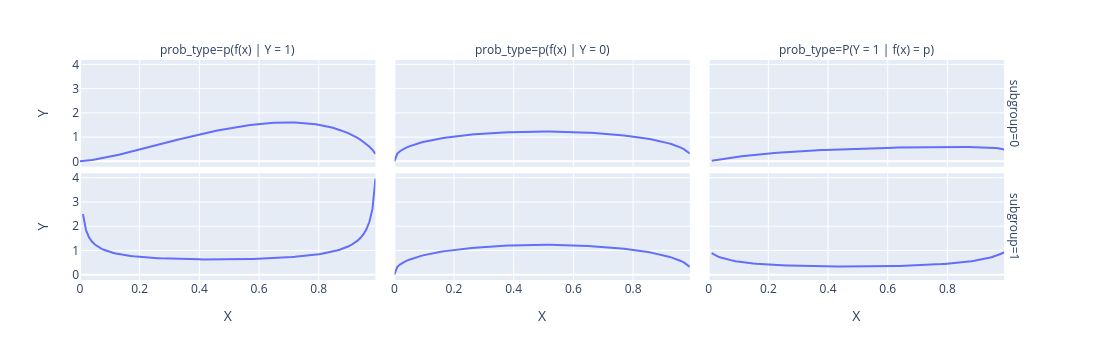

In [175]:
M1.viz()

/tmp/ipykernel_1344122/3434900514.py:59: RuntimeWarning:

invalid value encountered in divide



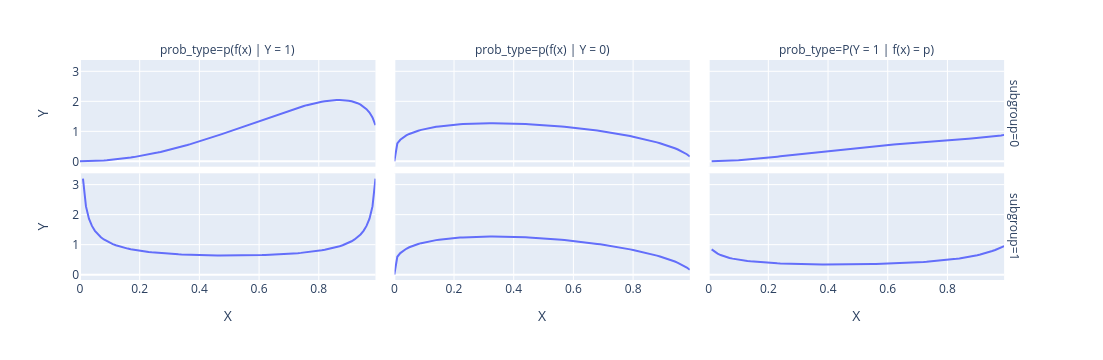

In [176]:
M2.viz()

In [226]:
%%time
E = ExperimentConfig(
    model_configs=[M1, M2],
    N_test = 100,
    N_validation = 100,
    subgroup_prevalences=[0.9, 0.1],
    prevalence=[0.8, 0.6],
    N_samples=1
)

data = E.run()

AssertionError: 

In [244]:
import scipy.stats as spstats

def model(
    pos_EV: float,
    pos_conf: float,
    neg_EV: float,
    neg_conf: float,
):
    return ModelConfig(pos_pred_EV=[pos_EV], pos_pred_confidence=[pos_conf], neg_pred_EV=[neg_EV], neg_pred_confidence=[neg_conf])

model_dist = {
    'pos_EV': spstats.uniform(0.01, 0.99),
    'neg_EV': spstats.uniform(0.01, 0.99),
    'pos_conf': spstats.uniform(-10, 10),
    'neg_conf': spstats.uniform(-10, 10),
}
prev_RV = spstats.uniform(0.01, 0.99)

deltas = []
best = None
best_delta = None
for sample in tqdm(list(range(100))):
    M1 = model(**{k: rvs.rvs() for k, rvs in model_dist.items()})
    M2 = model(**{k: rvs.rvs() for k, rvs in model_dist.items()})
    prev = prev_RV.rvs()
    E = ExperimentConfig(
        model_configs=[M1, M2],
        N_test = 200,
        N_validation = 200,
        subgroup_prevalences=[1],
        prevalence=[prev],
        N_samples=1
    )

    out = E.run()

    out = out.filter(pl.col("subgroup") == "ALL")

    AUROC_delta = (out.filter(pl.col("model") == 0)["AUROC"].item() - out.filter(pl.col("model") == 1)["AUROC"].item())
    AUPRC_delta = (out.filter(pl.col("model") == 0)["AUPRC"].item() - out.filter(pl.col("model") == 1)["AUPRC"].item())

    slope = AUPRC_delta / AUROC_delta

    key = (M1, M2, prev, E, out, AUROC_delta, AUPRC_delta)
    deltas.append(key)

    if best is None:
        best_delta = slope
        best = key
    elif slope < best_delta:
        best_delta = slope
        best = key

  0%|          | 0/100 [00:00<?, ?it/s]

In [245]:
best_delta

-3.079864112886086

In [246]:
best

(ModelConfig(pos_pred_EV=[0.19485782449698477], pos_pred_confidence=[-9.398477660112434], neg_pred_EV=[0.3670923395538934], neg_pred_confidence=[-0.8506707482401907]),
 ModelConfig(pos_pred_EV=[0.5143136851761114], pos_pred_confidence=[-5.40092812579103], neg_pred_EV=[0.8454904578989302], neg_pred_confidence=[-3.5445011229314973]),
 0.3696978445386086,
 ExperimentConfig(model_configs=[ModelConfig(pos_pred_EV=[0.19485782449698477], pos_pred_confidence=[-9.398477660112434], neg_pred_EV=[0.3670923395538934], neg_pred_confidence=[-0.8506707482401907]), ModelConfig(pos_pred_EV=[0.5143136851761114], pos_pred_confidence=[-5.40092812579103], neg_pred_EV=[0.8454904578989302], neg_pred_confidence=[-3.5445011229314973])], N_test=200, N_validation=200, subgroup_prevalences=[1], prevalence=[0.3696978445386086], N_samples=1),
 shape: (2, 8)
 ┌──────────┬────────┬───────┬──────────┬──────────┬─────────────┬──────────┬──────────┐
 │ subgroup ┆ sample ┆ model ┆ AUROC    ┆ AUPRC    ┆ Brier Score ┆ Accur

In [247]:
E = ExperimentConfig(
    model_configs=best[:2],
    N_test = 200,
    N_validation = 200,
    subgroup_prevalences=[1],
    prevalence=[best[2]],
    N_samples=5
)

In [248]:
out = E.run()

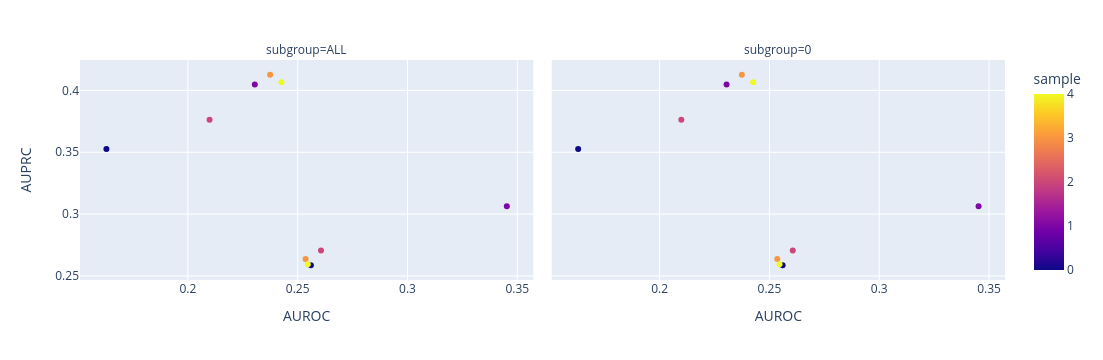

In [249]:
px.scatter(out, x="AUROC", y="AUPRC", facet_col="subgroup", color="sample")

In [253]:
E = ExperimentConfig(
    model_configs=best[:2],
    N_test = 5000,
    N_validation = 50,
    subgroup_prevalences=[1],
    prevalence=[best[2]],
    N_samples=10
)

out = E.run()

/tmp/ipykernel_1344122/2348093154.py:60: RuntimeWarning:

invalid value encountered in divide



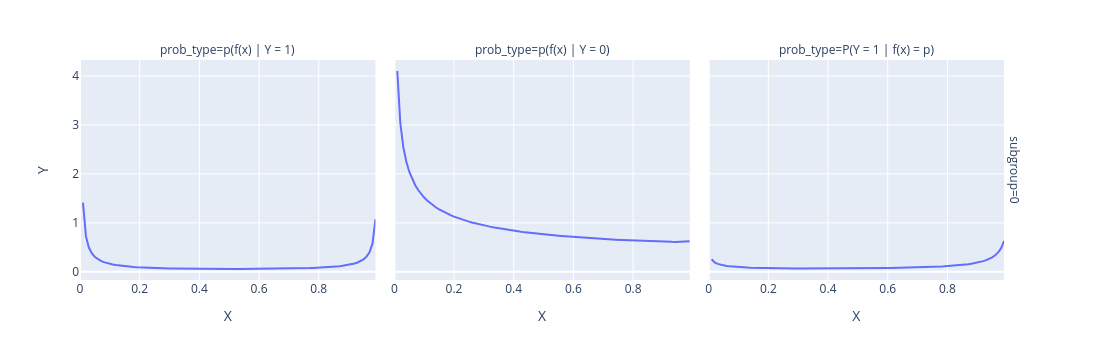

In [256]:
best[0].viz()

In [262]:
pos_samps = best[1].pos_rvs[0].rvs(100)
neg_samps = best[1].neg_rvs[0].rvs(100)
print((pos_samps > neg_samps).mean())

0.31


/tmp/ipykernel_1344122/2348093154.py:60: RuntimeWarning:

invalid value encountered in divide



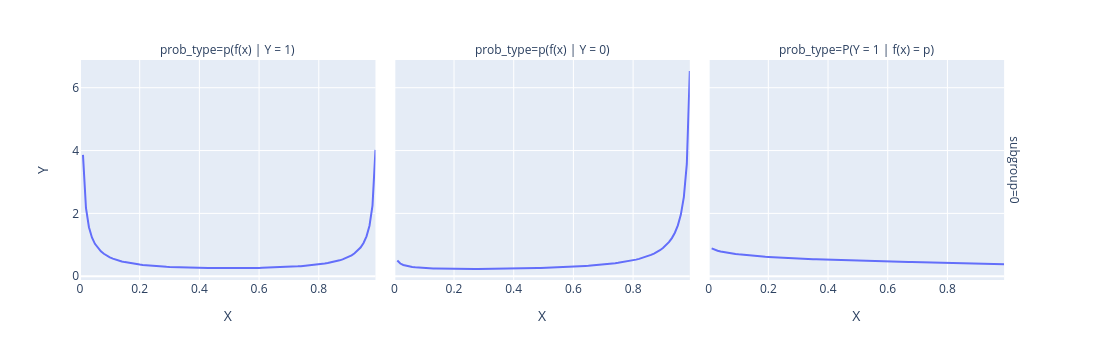

In [257]:
best[1].viz()

In [261]:
pos_samps = best[0].pos_rvs[0].rvs(100)
neg_samps = best[0].neg_rvs[0].rvs(100)
print((pos_samps > neg_samps).mean())

0.23


In [258]:
best[3]

ExperimentConfig(model_configs=[ModelConfig(pos_pred_EV=[0.19485782449698477], pos_pred_confidence=[-9.398477660112434], neg_pred_EV=[0.3670923395538934], neg_pred_confidence=[-0.8506707482401907]), ModelConfig(pos_pred_EV=[0.5143136851761114], pos_pred_confidence=[-5.40092812579103], neg_pred_EV=[0.8454904578989302], neg_pred_confidence=[-3.5445011229314973])], N_test=200, N_validation=200, subgroup_prevalences=[1], prevalence=[0.3696978445386086], N_samples=1)

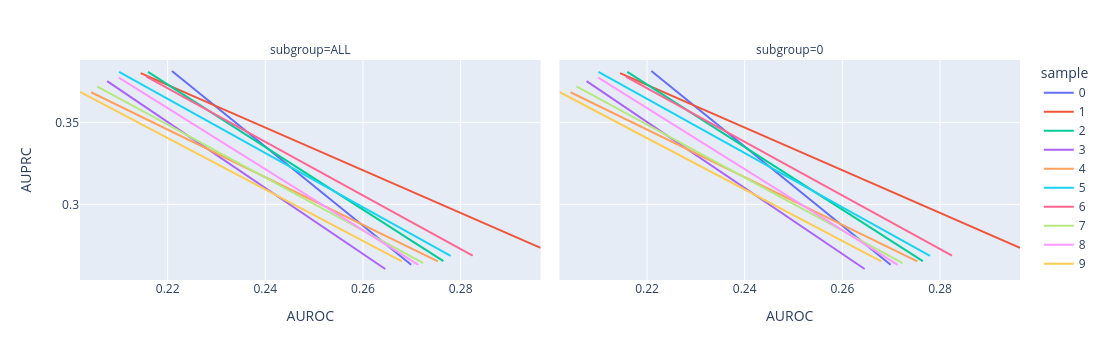

In [255]:
px.line(out, x="AUROC", y="AUPRC", facet_col="subgroup", color="sample")

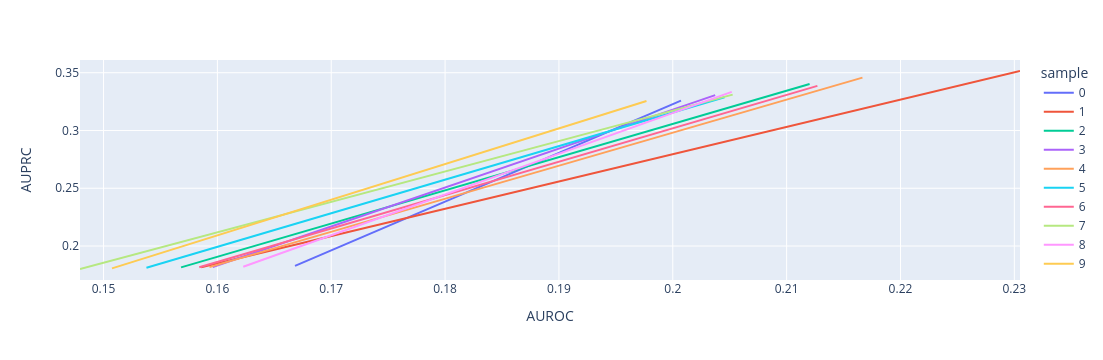

In [268]:
M1 = ModelConfig(
    pos_pred_EV=[0.2], pos_pred_confidence=[-10], neg_pred_EV=[0.4], neg_pred_confidence=[-1]
)

M2 = ModelConfig(
    pos_pred_EV=[0.2], pos_pred_confidence=[-1], neg_pred_EV=[0.6], neg_pred_confidence=[-1]
)

prev = 0.3

E = ExperimentConfig(
    model_configs=[M1, M2],
    N_test = 5000,
    N_validation = 50,
    subgroup_prevalences=[1],
    prevalence=[prev],
    N_samples=10
)

out = E.run().filter(pl.col("subgroup") == "ALL")

px.line(out, x="AUROC", y="AUPRC", color="sample")

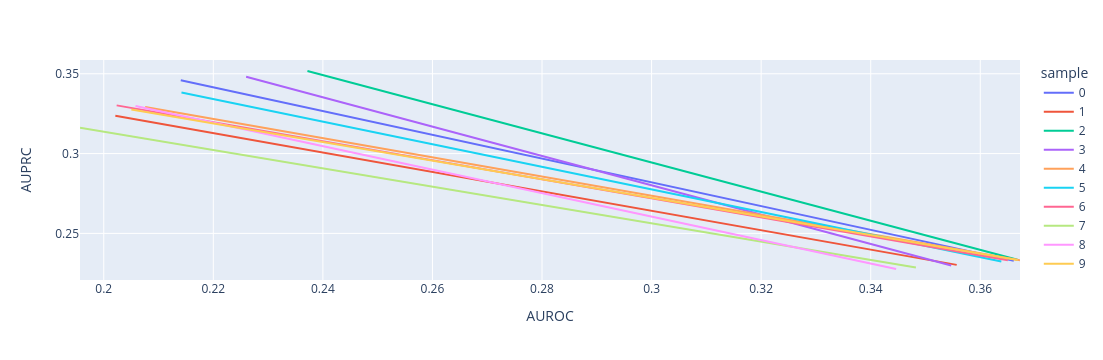

In [269]:
M1 = ModelConfig(
    pos_pred_EV=[0.2], pos_pred_confidence=[-10], neg_pred_EV=[0.4], neg_pred_confidence=[-1]
)

M2 = ModelConfig(
    pos_pred_EV=[0.2], pos_pred_confidence=[-1], neg_pred_EV=[0.6], neg_pred_confidence=[-10]
)

prev = 0.3

E = ExperimentConfig(
    model_configs=[M1, M2],
    N_test = 5000,
    N_validation = 50,
    subgroup_prevalences=[1],
    prevalence=[prev],
    N_samples=10
)

out = E.run().filter(pl.col("subgroup") == "ALL")

px.line(out, x="AUROC", y="AUPRC", color="sample")

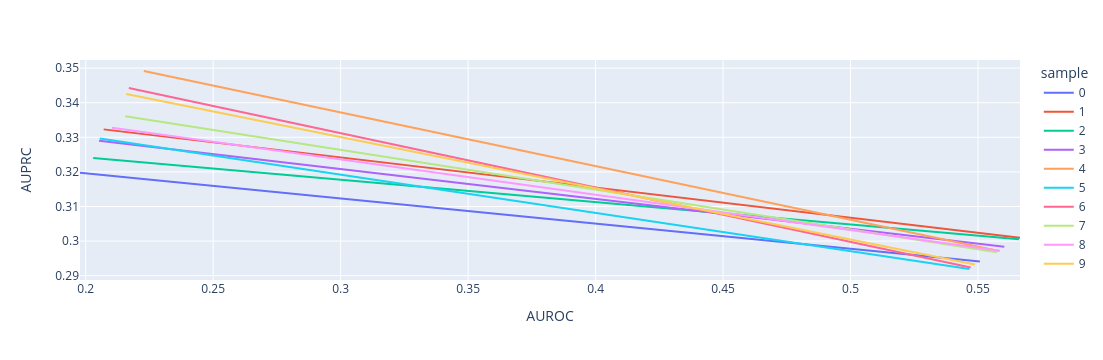

In [270]:
M1 = ModelConfig(
    pos_pred_EV=[0.2], pos_pred_confidence=[-10], neg_pred_EV=[0.4], neg_pred_confidence=[-1]
)

M2 = ModelConfig(
    pos_pred_EV=[0.2], pos_pred_confidence=[-1], neg_pred_EV=[0.4], neg_pred_confidence=[-10]
)

prev = 0.3

E = ExperimentConfig(
    model_configs=[M1, M2],
    N_test = 5000,
    N_validation = 50,
    subgroup_prevalences=[1],
    prevalence=[prev],
    N_samples=10
)

out = E.run().filter(pl.col("subgroup") == "ALL")

px.line(out, x="AUROC", y="AUPRC", color="sample")

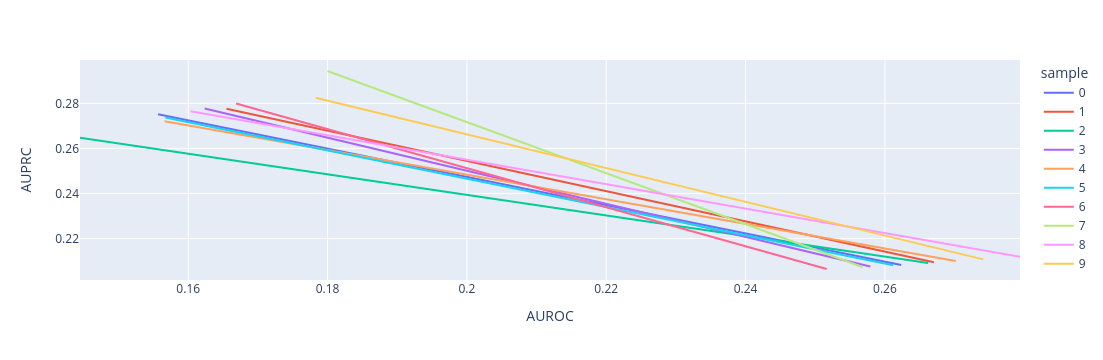

In [273]:
M1 = ModelConfig(
    pos_pred_EV=[0.2], pos_pred_confidence=[1], neg_pred_EV=[0.4], neg_pred_confidence=[12]
)

M2 = ModelConfig(
    pos_pred_EV=[0.2], pos_pred_confidence=[12], neg_pred_EV=[0.4], neg_pred_confidence=[1]
)

prev = 0.3

E = ExperimentConfig(
    model_configs=[M1, M2],
    N_test = 5000,
    N_validation = 50,
    subgroup_prevalences=[1],
    prevalence=[prev],
    N_samples=10
)

out = E.run().filter(pl.col("subgroup") == "ALL")

px.line(out, x="AUROC", y="AUPRC", color="sample")

/tmp/ipykernel_1344122/2348093154.py:60: RuntimeWarning:

invalid value encountered in divide



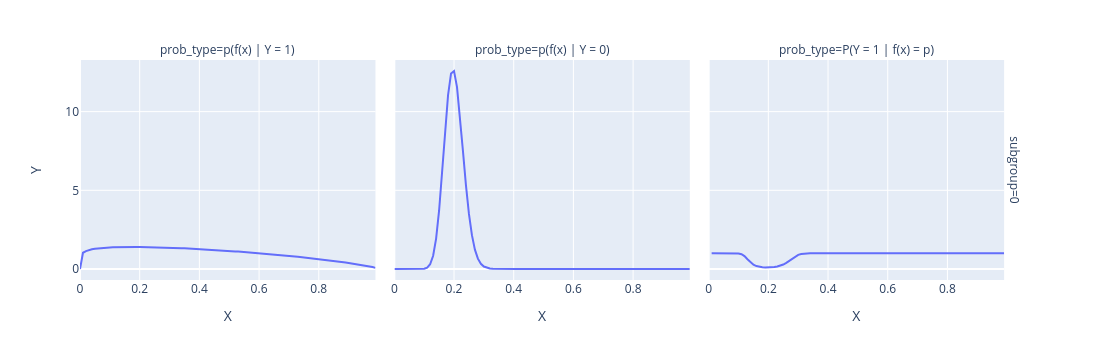

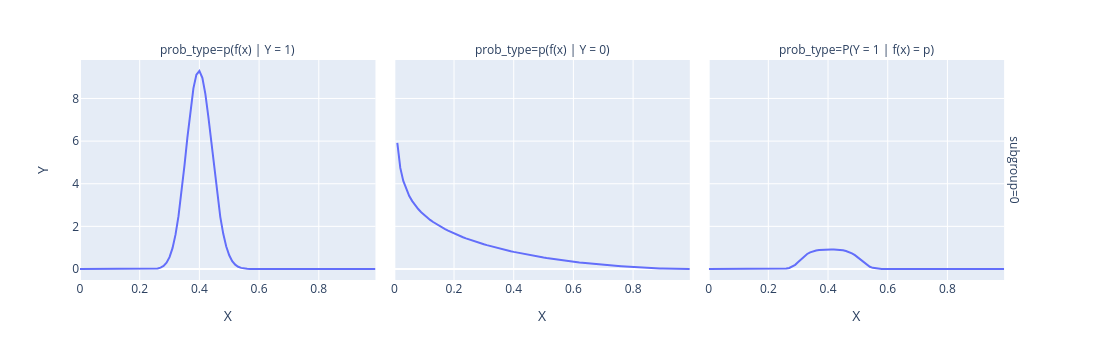

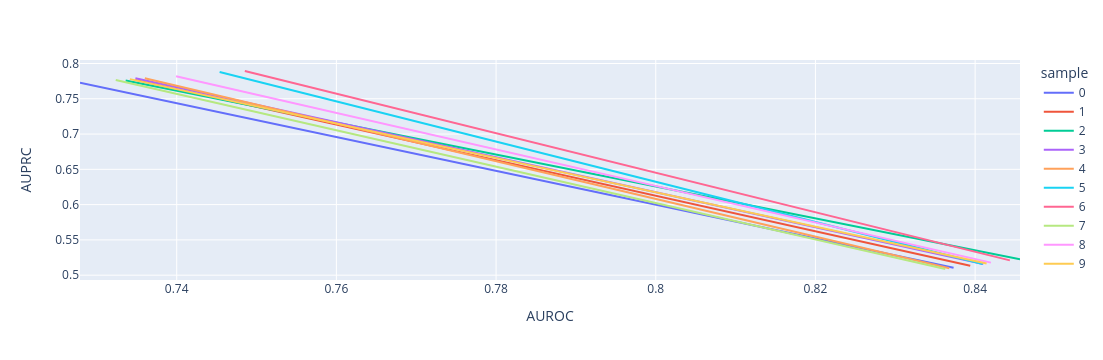

In [280]:
M1 = ModelConfig(
    pos_pred_EV=[0.4], pos_pred_confidence=[1], neg_pred_EV=[0.2], neg_pred_confidence=[12]
)

M2 = ModelConfig(
    pos_pred_EV=[0.4], pos_pred_confidence=[12], neg_pred_EV=[0.2], neg_pred_confidence=[1]
)

display(M1.viz())
display(M2.viz())

prev = 0.3

E = ExperimentConfig(
    model_configs=[M1, M2],
    N_test = 15000,
    N_validation = 50,
    subgroup_prevalences=[1],
    prevalence=[prev],
    N_samples=10
)

out = E.run().filter(pl.col("subgroup") == "ALL")

px.line(out, x="AUROC", y="AUPRC", color="sample")

/tmp/ipykernel_1344122/2348093154.py:60: RuntimeWarning:

invalid value encountered in divide



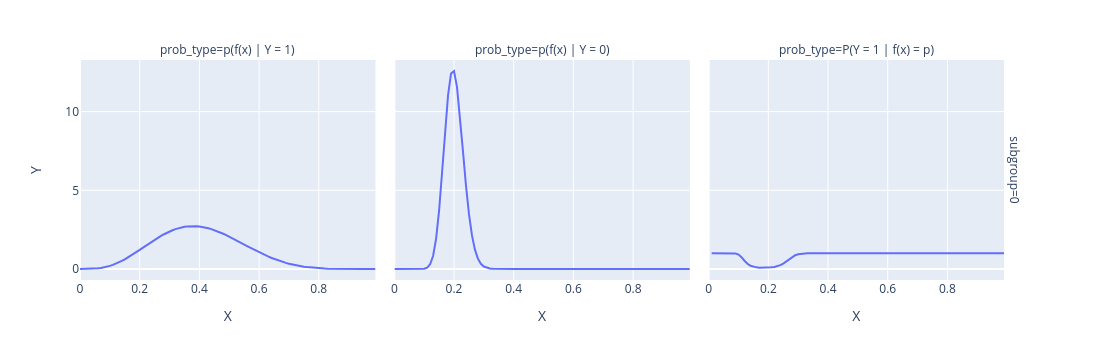

/tmp/ipykernel_1344122/2348093154.py:60: RuntimeWarning:

invalid value encountered in divide



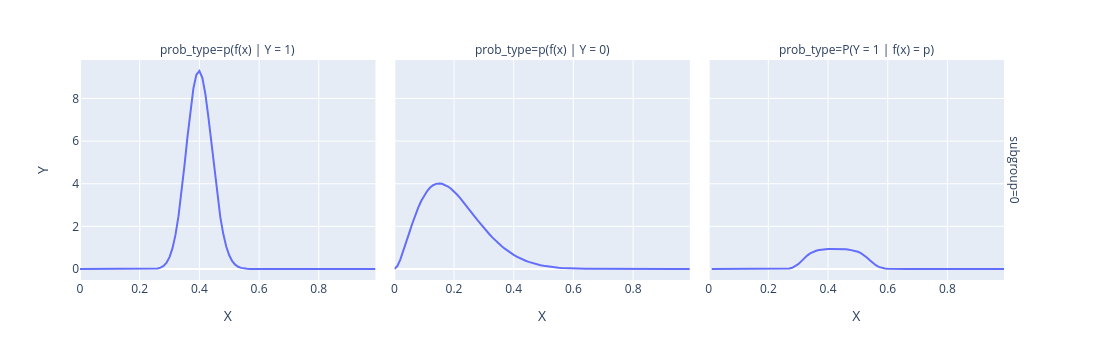

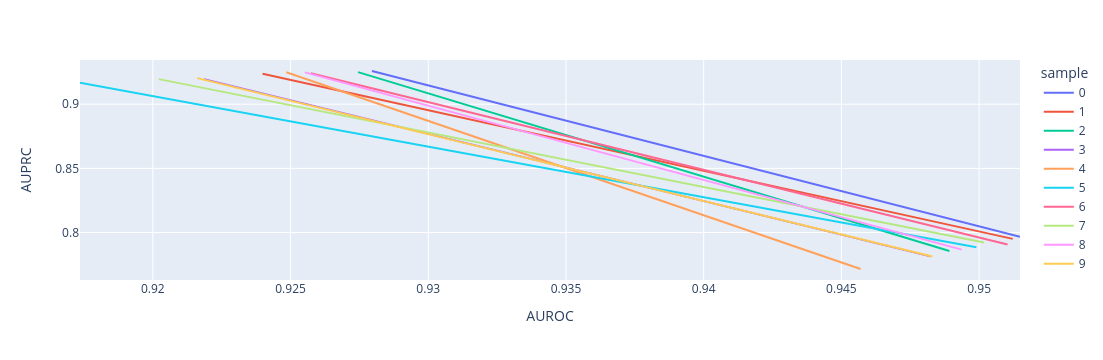

In [281]:
M1 = ModelConfig(
    pos_pred_EV=[0.4], pos_pred_confidence=[5], neg_pred_EV=[0.2], neg_pred_confidence=[12]
)

M2 = ModelConfig(
    pos_pred_EV=[0.4], pos_pred_confidence=[12], neg_pred_EV=[0.2], neg_pred_confidence=[5]
)

display(M1.viz())
display(M2.viz())

prev = 0.3

E = ExperimentConfig(
    model_configs=[M1, M2],
    N_test = 15000,
    N_validation = 50,
    subgroup_prevalences=[1],
    prevalence=[prev],
    N_samples=10
)

out = E.run().filter(pl.col("subgroup") == "ALL")

px.line(out, x="AUROC", y="AUPRC", color="sample")

CPU times: user 3min 10s, sys: 6.86 s, total: 3min 17s
Wall time: 3min 11s


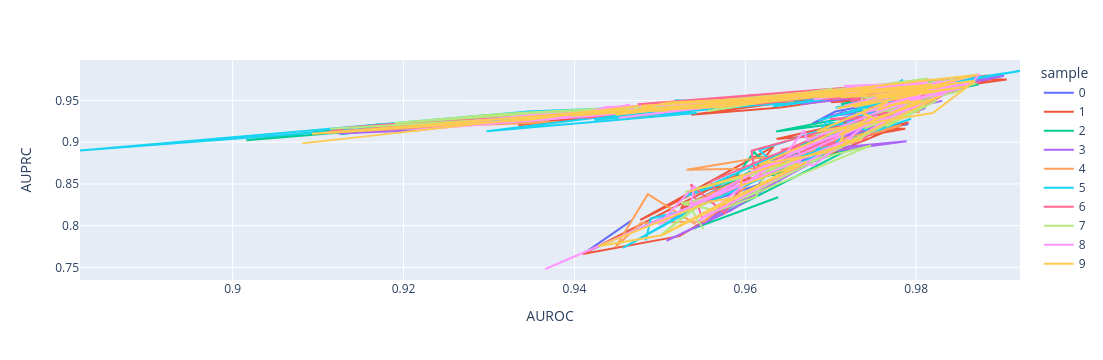

In [284]:
%%time
Ms = []

for conf_lvl in np.arange(0., 7., 1/10.):
    Ms.append(ModelConfig(
        pos_pred_EV=[0.4], pos_pred_confidence=[5+conf_lvl], neg_pred_EV=[0.2], neg_pred_confidence=[12-conf_lvl]
    ))

prev = 0.3

E = ExperimentConfig(
    model_configs=Ms,
    N_test = 500,
    N_validation = 50,
    subgroup_prevalences=[1],
    prevalence=[prev],
    N_samples=10
)

out = E.run().filter(pl.col("subgroup") == "ALL")

display(px.line(out, x="AUROC", y="AUPRC", color="sample"))

o = (
    out.drop(columns=["subgroup"])
    .groupby("model")
    .agg(pl.col("AUROC").mean(), pl.col("AUPRC").mean())
    .sort(by="model")
)

px.line(o, x="AUROC", y="AUPRC")

/tmp/ipykernel_1344122/2348093154.py:60: RuntimeWarning:

invalid value encountered in divide



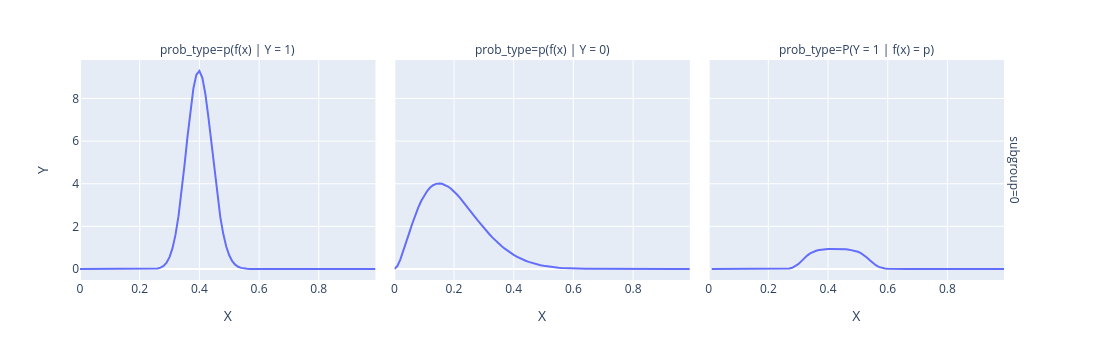

/tmp/ipykernel_1344122/2348093154.py:60: RuntimeWarning:

invalid value encountered in divide



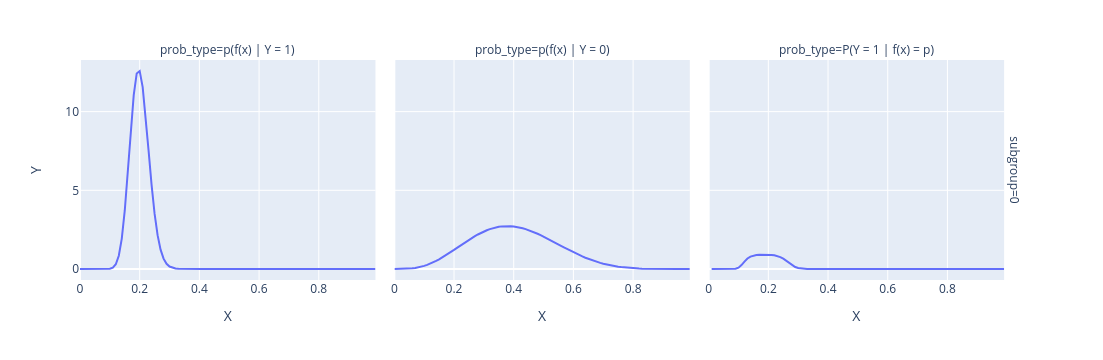

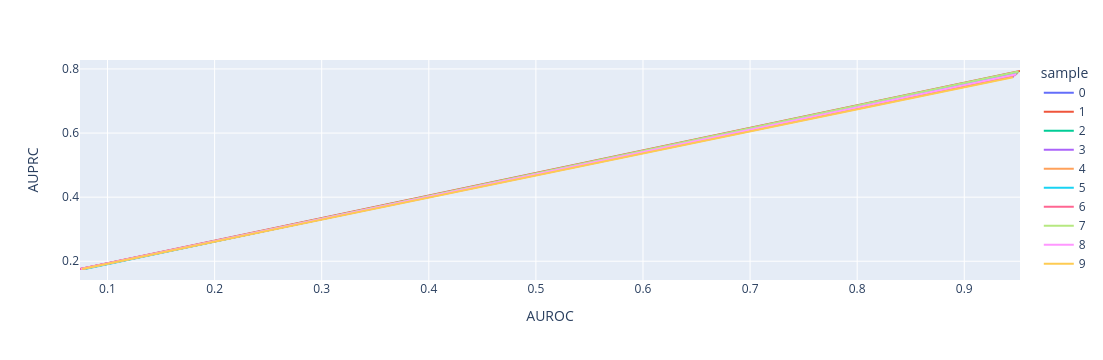

In [293]:
M1 = ModelConfig(
    pos_pred_EV=[0.4], pos_pred_confidence=[12], neg_pred_EV=[0.2], neg_pred_confidence=[5]
)

M2 = ModelConfig(
    pos_pred_EV=[0.2], pos_pred_confidence=[12], neg_pred_EV=[0.4], neg_pred_confidence=[5]
)

display(M1.viz())
display(M2.viz())

prev = 0.3

E = ExperimentConfig(
    model_configs=[M1, M2],
    N_test = 15000,
    N_validation = 50,
    subgroup_prevalences=[1],
    prevalence=[prev],
    N_samples=10
)

out = E.run().filter(pl.col("subgroup") == "ALL")

px.line(out, x="AUROC", y="AUPRC", color="sample")

/tmp/ipykernel_1344122/2348093154.py:60: RuntimeWarning:

invalid value encountered in divide



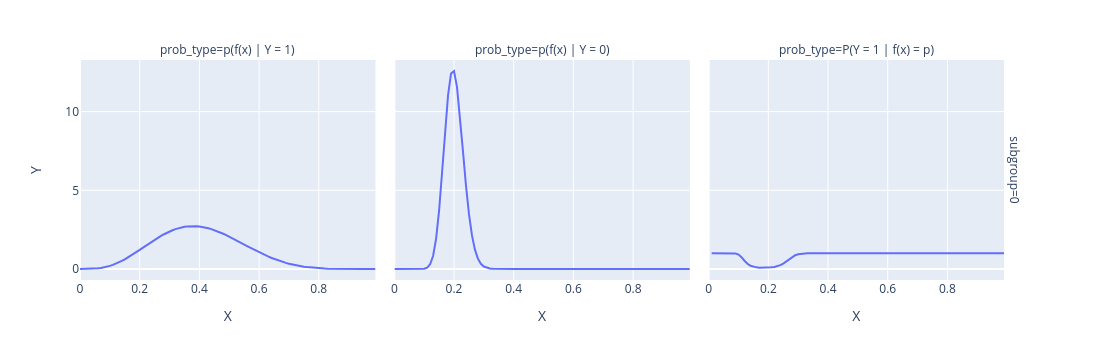

/tmp/ipykernel_1344122/2348093154.py:60: RuntimeWarning:

invalid value encountered in divide



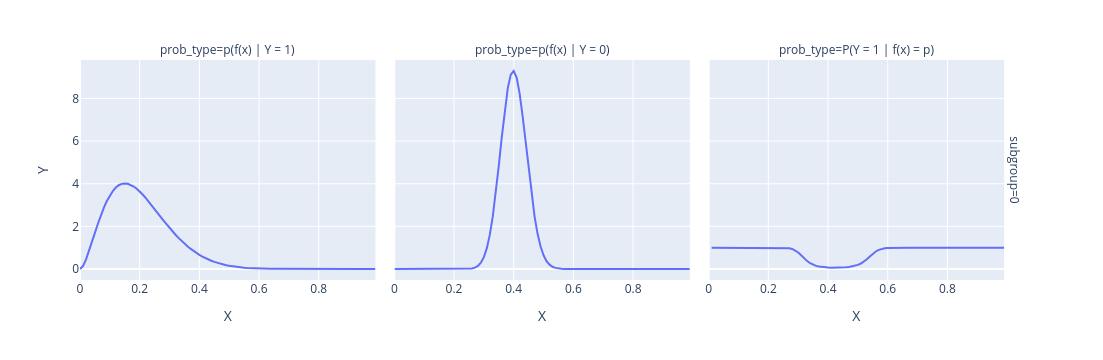

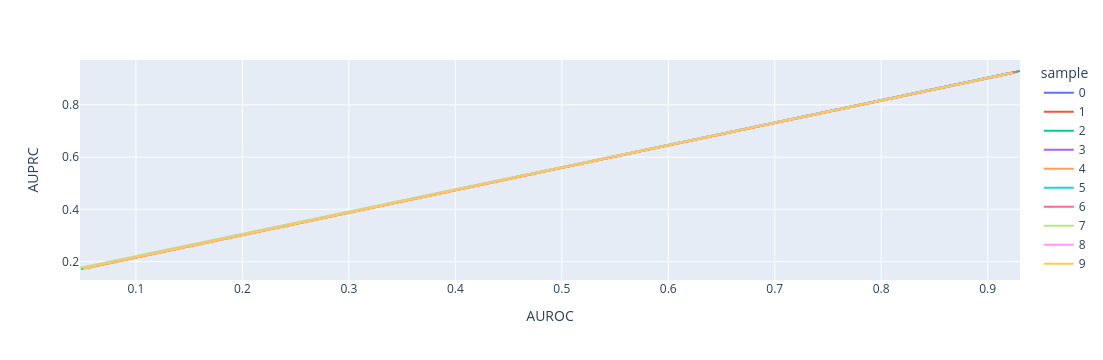

In [292]:
M1 = ModelConfig(
    pos_pred_EV=[0.4], pos_pred_confidence=[5], neg_pred_EV=[0.2], neg_pred_confidence=[12]
)

M2 = ModelConfig(
    pos_pred_EV=[0.2], pos_pred_confidence=[5], neg_pred_EV=[0.4], neg_pred_confidence=[12]
)

display(M1.viz())
display(M2.viz())

prev = 0.3

E = ExperimentConfig(
    model_configs=[M1, M2],
    N_test = 15000,
    N_validation = 50,
    subgroup_prevalences=[1],
    prevalence=[prev],
    N_samples=10
)

out = E.run().filter(pl.col("subgroup") == "ALL")

px.line(out, x="AUROC", y="AUPRC", color="sample")

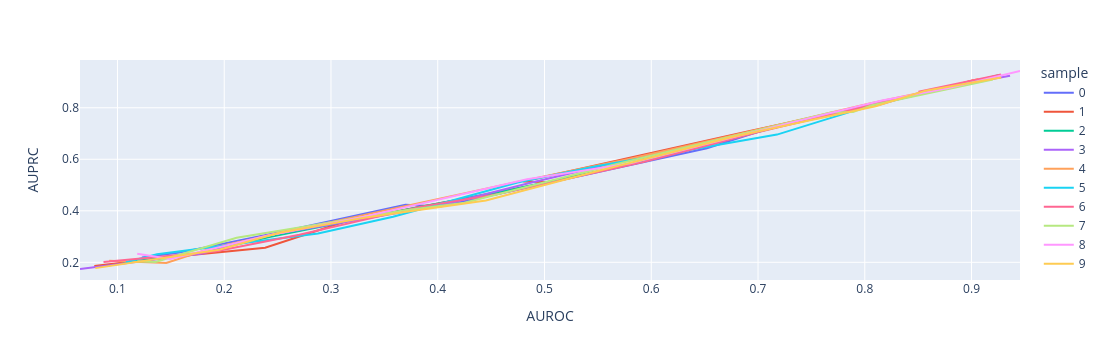

CPU times: user 23.6 s, sys: 828 ms, total: 24.4 s
Wall time: 23.8 s


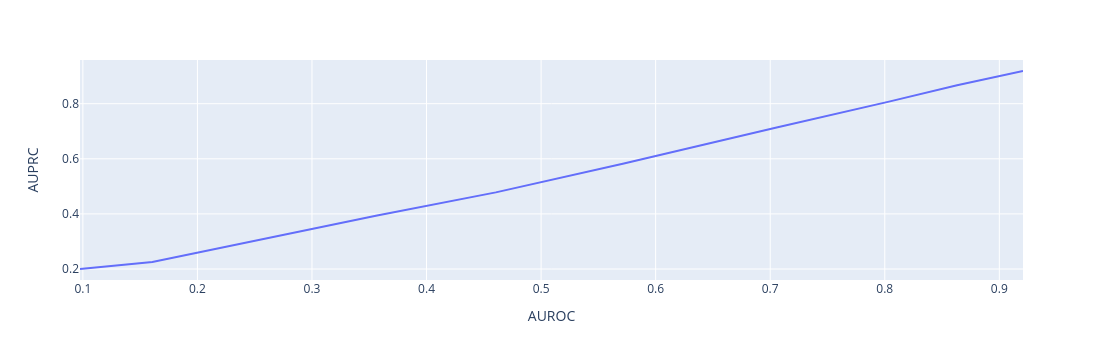

In [294]:
%%time
Ms = []

for pos_neg_axis in np.arange(0., 0.2, 1/50.):
    Ms.append(ModelConfig(
        pos_pred_EV=[0.4-pos_neg_axis], pos_pred_confidence=[5], neg_pred_EV=[0.2+pos_neg_axis], neg_pred_confidence=[12]
    ))

prev = 0.3

E = ExperimentConfig(
    model_configs=Ms,
    N_test = 500,
    N_validation = 50,
    subgroup_prevalences=[1],
    prevalence=[prev],
    N_samples=10
)

out = E.run().filter(pl.col("subgroup") == "ALL")

display(px.line(out, x="AUROC", y="AUPRC", color="sample"))

o = (
    out.drop(columns=["subgroup"])
    .groupby("model")
    .agg(pl.col("AUROC").mean(), pl.col("AUPRC").mean())
    .sort(by="model")
)

px.line(o, x="AUROC", y="AUPRC")